In [1]:
import numpy as np
import sep

### Final Project Code (Some images in GitHub separately)

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
file_path = "/Users/joeymckeown/Desktop/ASTR19CODE/final_project/MAST_2025-06-08T2032/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits"

hdul = fits.open(file_path)
data = hdul[1].data.astype(float)
#hdul.info()

In [4]:
def rescale_image(data,vmin=0.5,vmax=100):
    # copy the data to avoid accidentaly overwriting it
    data_tmp = data.copy()

    # compute the mean value over all data, excluding NaN (Not a Number)
    m = np.nanmean(data_tmp)

    # any data points below vpmin is assigned the value vpmin
    # any data points above vpmax is assigned the value vpmax
    vpmin = vmin * m
    vpmax = vmax * m
    data_tmp[data_tmp < vpmin] = vpmin
    data_tmp[data_tmp > vpmax] = vpmax
    
    # replace all NaN by vpmin
    data_tmp = np.nan_to_num(data_tmp,nan=vpmin)

    # apply log-scale
    data_tmp = np.log10(data_tmp)
    return data_tmp

In [5]:
rescaled_data = rescale_image(data)
print(rescaled_data.shape)

(8582, 14339)


### Image commented due to memory issues, will attach picture to GitHub

In [6]:
# Show image
#m, s = np.mean(rescaled_data), np.std(rescaled_data)
#plt.imshow(rescaled_data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
#plt.colorbar();
#plt.savefig('f090wfits.png')

In [7]:
bkg = sep.Background(data)

In [8]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

1.1956995725631714
0.06582547724246979


In [9]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

### Background commented due to memory issues, will attach picture to GitHub

In [10]:
# show the background
#plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
#plt.colorbar();
#plt.savefig('background.png')

In [11]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

### Background noise commented due to memory issues, will attach picture to GitHub

In [12]:
# show the background noise
#plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
#plt.colorbar();
#plt.savefig('backgroundnoise.png')

In [13]:
# subtract the background
data_sub = data - bkg

In [14]:
objects = sep.extract(data_sub, 10, err=bkg.globalrms) # increased threshold to 10 for memory reasons

In [15]:
# how many objects were detected
print(f"{len(objects)} objects were detected")

12016 objects were detected


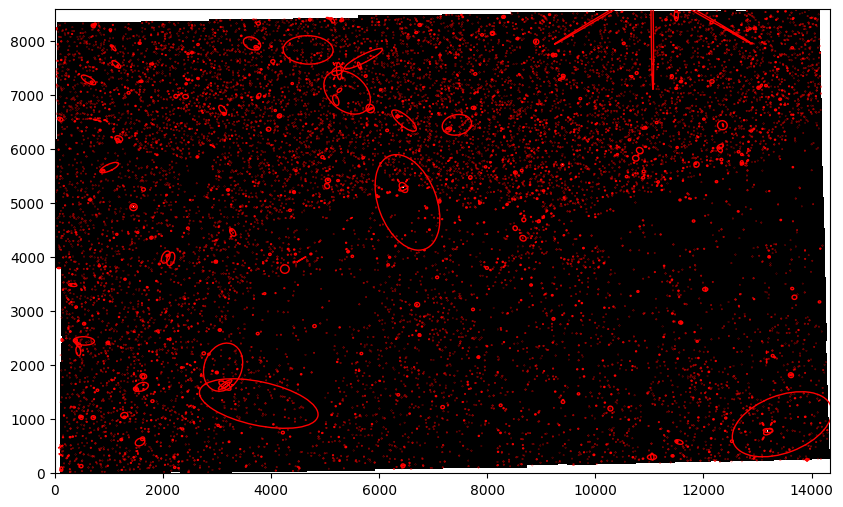

In [16]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('backgroundsubtracted.png')

In [17]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

In [18]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [19]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 36.514958 +/- 6.052934
object 1: flux = 10.580278 +/- 3.271436
object 2: flux = 249.279545 +/- 15.792458
object 3: flux = 35.355510 +/- 5.956287
object 4: flux = 472.214315 +/- 21.733312
object 5: flux = 13.704591 +/- 3.718461
object 6: flux = 55.563688 +/- 7.462332
object 7: flux = 79.149599 +/- 8.903490
object 8: flux = 19.981370 +/- 4.483757
object 9: flux = 15.242723 +/- 3.919921



Number of bins: 3824
The lack of objects on this histogram is most likely due to the amount of objects that had NaN, etc. as a flux value


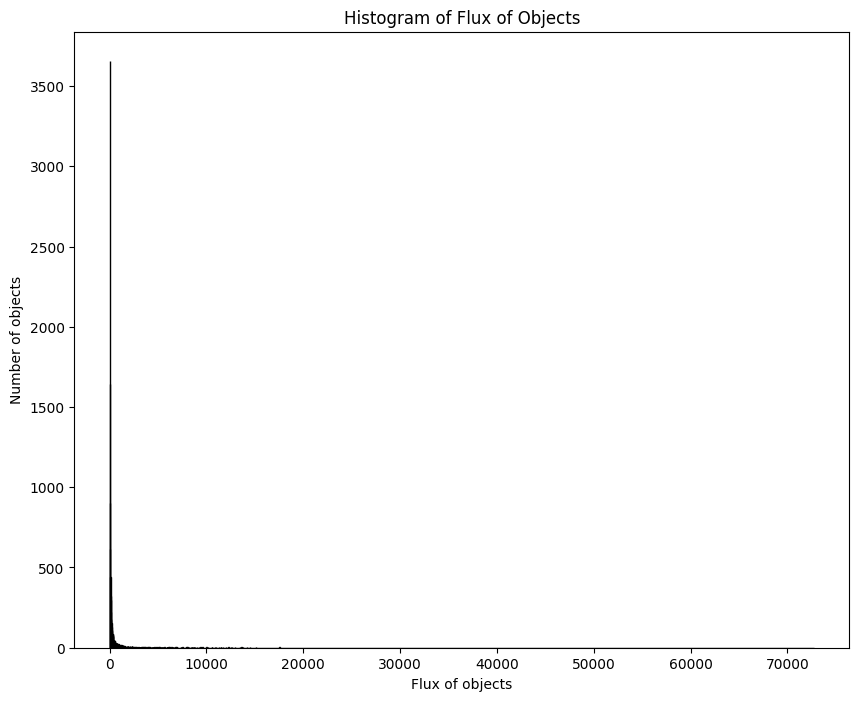

In [23]:
counts, bin_edges, patches = plt.hist(flux, bins='fd', color='lightblue', edgecolor='black', alpha=1) #uses fd to automatically create bin count

num_bins = len(bin_edges) - 1
print()
print("Number of bins:", num_bins)
print("The lack of objects on this histogram is most likely due to the amount of objects that had NaN, etc. as a flux value")

plt.xlabel('Flux of objects')
plt.ylabel('Number of objects')
plt.title("Histogram of Flux of Objects")
plt.show()


In [21]:
mean_flux = np.nanmean(flux) # adding 'nan' skips over nans without affecting the array size
median_flux = np.nanmedian(flux)
std_flux = np.nanstd(flux)

print(f"Mean flux: {mean_flux}")
print(f"Median flux: {median_flux}")
print(f"Standard deviation of flux: {std_flux}")

Mean flux: 642.3644786338128
Median flux: 56.75320646286012
Standard deviation of flux: 2226.5275624504734


In [22]:
max_flux = np.nanmax(flux)
max_index = np.nanargmax(flux)

num_std_devs = (max_flux - mean_flux) / std_flux

# find source coordinates on image
x_pos = objects['x'][max_index]
y_pos = objects['y'][max_index]


print(f"Largest outlier: {max_flux}") # max flux is largest outlier because histogram is right skewed and this is measure of flux (apparent brightness)
                                      # therefore the largest outlier is the "brightest" object
print(f"Position on image (x, y): ({x_pos:.2f}, {y_pos:.2f})")
print(f"Number of standard deviations from mean: {num_std_devs:.2f}")

Largest outlier: 72769.94941894533
Position on image (x, y): (13195.36, 788.92)
Number of standard deviations from mean: 32.39


# Step 8 in other notebook due to lack of memory